# Weather Prediction in Australia

### Objective

The goal of this project is to predict whether it will rain the following day by training classification models on the target variable `RainTomorrow`.

### Dataset Description

This dataset contains approximately 10 years of daily weather observations collected from various locations across Australia.

The target variable, `RainTomorrow`, indicates whether it rained the next day. It is a binary categorical variable:
- **Yes**: if the recorded rainfall for the following day was **1 mm or more**.
- **No**: if the recorded rainfall was less than 1 mm.

### Importing Libraries

First, we import the libraries that will be used throughout the project.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import tensorflow as tf

### Loading the Dataset

We load the dataset containing weather observations from various locations across Australia over a 10-year period (2008–2017).  
The data is assigned to the variable `weather`, which will serve as a DataFrame for exploring, managing, and visualizing the information.

In [3]:
weather_df = pd.read_csv("../data/weatherAUS.csv")
weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Exploring Dataset Structure

We now display relevant information about the dataset, including the variable names, data types, and the number of non-null entries for each column.

In [32]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

This visualization provides a more detailed view of the data types for each variable, as well as the number of non-null and null entries per column.

As we can see, the dataset contains **145,460 records**, but several columns—such as `Evaporation`, `Sunshine`, `Cloud9am`, and `Cloud3pm`—have a significant number of missing values.

Before proceeding with data cleaning, we need to decide how to handle these missing entries appropriately.

### Variable Descriptions

Before diving deeper, here's a brief explanation of the information captured by each column in the dataset:

- **`Date`**: The date of the observation.
- **`Location`**: The common name of the weather station's location.
- **`MinTemp`**: Minimum temperature (°C) recorded on the day.
- **`MaxTemp`**: Maximum temperature (°C) recorded on the day.
- **`Rainfall`**: Amount of rainfall recorded for the day (in mm).
- **`Evaporation`**: Class A pan evaporation (in mm) measured over the 24 hours to 9am.
- **`Sunshine`**: Number of hours of bright sunshine during the day.
- **`WindGustDir`**: Direction of the strongest wind gust in the 24 hours to midnight.
- **`WindGustSpeed`**: Speed (km/h) of the strongest wind gust in the 24 hours to midnight.
- **`WindDir9am`**: Wind direction at 9am.
- **`WindDir3pm`**: Wind direction at 3pm.
- **`WindSpeed9am`**: Wind speed (km/h), averaged over 10 minutes prior to 9am.
- **`WindSpeed3pm`**: Wind speed (km/h), averaged over 10 minutes prior to 3pm.
- **`Humidity9am`**: Humidity (%) at 9am.
- **`Humidity3pm`**: Humidity (%) at 3pm.
- **`Pressure9am`**: Atmospheric pressure (hPa), reduced to mean sea level, at 9am.
- **`Pressure3pm`**: Atmospheric pressure (hPa), reduced to mean sea level, at 3pm.
- **`Cloud9am`**: Fraction of the sky covered by cloud at 9am, measured in *oktas* (eighths).
- **`Cloud3pm`**: Fraction of the sky covered by cloud at 3pm, also measured in *oktas*. See `Cloud9am` for details.
- **`Temp9am`**: Temperature (°C) at 9am.
- **`Temp3pm`**: Temperature (°C) at 3pm.
- **`RainToday`**: Boolean: 1 if rainfall in the 24 hours to 9am exceeded 1mm, otherwise 0.
- **`RainTomorrow`**: Rainfall amount for the following day (in mm). Used to generate the target variable `RainTomorrow`, indicating the likelihood of rain.

In [33]:
weather_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


We now examine the number of missing or unknown (`NaN`) values in each variable.

In [34]:
print("Percentage of Missing Data per Variable: \n")
columnas = [nombre for nombre in weather_df.columns]
print(round(weather_df[columnas].isnull().sum()/ weather_df.shape[0], 2))

Percentage of Missing Data per Variable: 

Date             0.00
Location         0.00
MinTemp          0.01
MaxTemp          0.01
Rainfall         0.02
Evaporation      0.43
Sunshine         0.48
WindGustDir      0.07
WindGustSpeed    0.07
WindDir9am       0.07
WindDir3pm       0.03
WindSpeed9am     0.01
WindSpeed3pm     0.02
Humidity9am      0.02
Humidity3pm      0.03
Pressure9am      0.10
Pressure3pm      0.10
Cloud9am         0.38
Cloud3pm         0.41
Temp9am          0.01
Temp3pm          0.02
RainToday        0.02
RainTomorrow     0.02
dtype: float64


We create a visual representation of the missing data percentages to better understand the extent of missingness in each variable.

Notably, there are four variables with a particularly high percentage of missing values. These variables will be removed from the dataset, as attempting to impute them could introduce significant prediction errors.

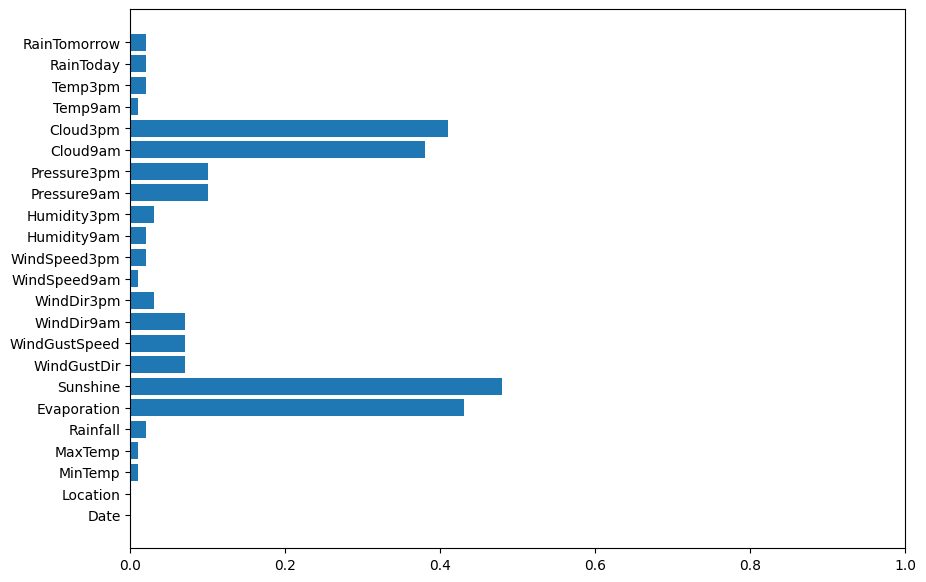

In [7]:
df_aux = pd.DataFrame(round(weather_df[columnas].isnull().sum()/ weather_df.shape[0], 2))
plt.figure(figsize=(10,7))
plt.barh(df_aux.index, df_aux[0])
plt.xticks(np.arange(0, 1.2, step=0.2))
plt.show()

We notice that the target variable, `RainTomorrow`, contains missing values. These records must be removed, as they are not useful for training or testing the model.

Additionally, records without data for the `RainToday` variable will also be removed, as this variable is essential for predicting whether it will rain the following day.

In [8]:
weather_df.dropna(subset=['RainToday' , 'RainTomorrow'], inplace=True)

The next step will involve removing the four variables with more than 35% missing data: `Cloud3pm`, `Cloud9am`, `Sunshine`, and `Evaporation`.  
Additionally, we will remove the `Date` column, as it does not provide any useful information for our analysis.

An interesting approach would be to break down the `Date` variable into day and month components, and analyze whether these new variables have any correlation with the target variable we aim to predict.

In [9]:
weather_df.drop(columns=['Cloud3pm','Cloud9am','Sunshine','Evaporation', 'Date'],axis=1, inplace=True)

After removing the unnecessary columns, we proceed to handle the remaining columns with missing values.  
We begin with the numeric columns, where missing values will be replaced by the mean of the respective variable.  
We use list comprehensions to select these variables efficiently.

In [ ]:
var_num = [column for column in weather_df.columns if weather_df[column].dtype == 'float64']

for col in var_num:
    weather_df[col] = weather_df[col].fillna(weather_df[col].mean()) 

Next, we address the missing values in the categorical variables: `WindGustDir`, `WindGustSpeed`, and `WindDir3pm`.  
Since these are categorical variables, instead of replacing the missing values with the mean, we will replace them with the mode of each respective variable.

In [11]:
var_cat = [column for column in weather_df.columns if weather_df[column].dtype == 'object']

for col in var_cat:
    weather_df[col] = weather_df[col].fillna(weather_df[col].mode()[0]) 

We confirm that there are no longer any missing values in the dataset.

In [12]:
columnas = [nombre for nombre in weather_df.columns]
print(weather_df[columnas].isnull().sum())

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


The next step in our data preprocessing is to convert categorical variables into numeric ones.  
We will use ordinal encoding, assigning a unique value to each category, leveraging the `OrdinalEncoder` library for ease.  
A function will be created to handle this transformation.

In [14]:
def cat_a_num(df):
    array = list(df[df.columns[0]].unique())
    encoder = OrdinalEncoder(categories=[array])

    encoder.fit(weather_df[[df.columns[0]]])
    return encoder.transform(df[[df.columns[0]]])

We apply the function to each categorical variable, transforming all of them into numeric values.

In [15]:
for col in var_cat:
    weather_df[col] = cat_a_num(weather_df[[col]])
    weather_df[col] = weather_df[col].astype('int64')

We display information about the current state of the dataset. We can observe that there are no longer any missing records, all variables now have the same number of entries with data, and all variables are of numeric type (either integer or decimal).

In [16]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140787 entries, 0 to 145458
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       140787 non-null  int64  
 1   MinTemp        140787 non-null  float64
 2   MaxTemp        140787 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   WindGustDir    140787 non-null  int64  
 5   WindGustSpeed  140787 non-null  float64
 6   WindDir9am     140787 non-null  int64  
 7   WindDir3pm     140787 non-null  int64  
 8   WindSpeed9am   140787 non-null  float64
 9   WindSpeed3pm   140787 non-null  float64
 10  Humidity9am    140787 non-null  float64
 11  Humidity3pm    140787 non-null  float64
 12  Pressure9am    140787 non-null  float64
 13  Pressure3pm    140787 non-null  float64
 14  Temp9am        140787 non-null  float64
 15  Temp3pm        140787 non-null  float64
 16  RainToday      140787 non-null  int64  
 17  RainTomorrow   140787 non-null  in

We also display the first five rows of the dataset to visualize the changes made to the variables.

In [17]:
weather_df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,13.4,22.9,0.6,0,44.0,0,0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0
1,0,7.4,25.1,0.0,1,44.0,1,1,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0
2,0,12.9,25.7,0.0,2,46.0,0,1,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0
3,0,9.2,28.0,0.0,3,24.0,2,2,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0
4,0,17.5,32.3,1.0,0,41.0,3,3,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0


Once the data is cleaned and in the appropriate format, we will analyze the correlation between variables to remove any that are excessively correlated (as this could introduce errors in the prediction).  
To do this, we visualize a heatmap of the correlations.

<Axes: >

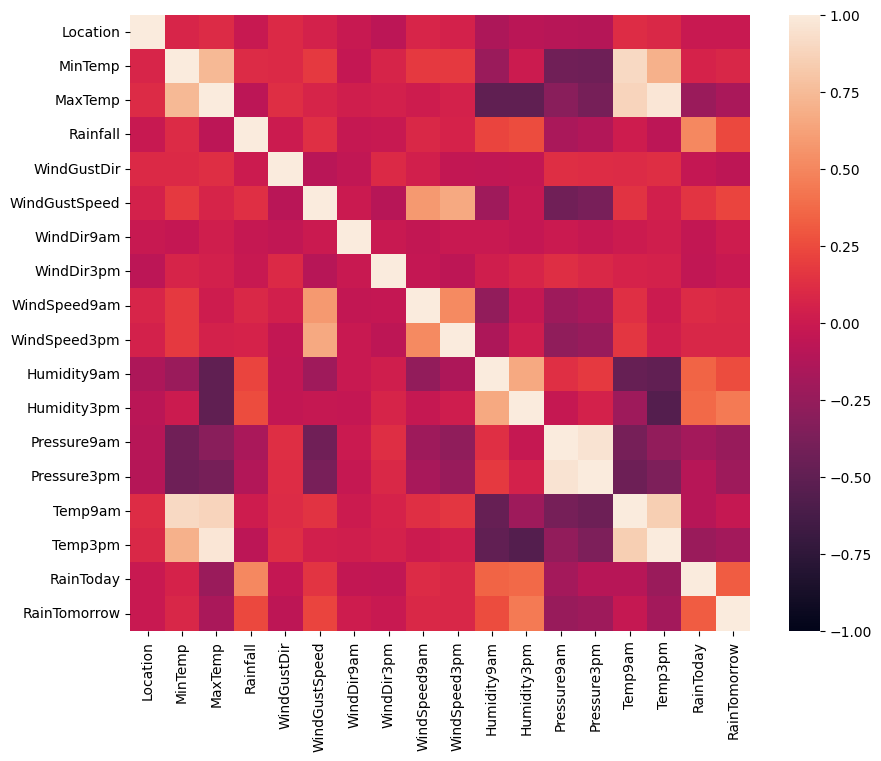

In [18]:
corr = weather_df.corr()

fig, ax = plt.subplots(figsize=(10,8))         
sns.heatmap(corr ,vmax=1, vmin=-1)

As we can see, there are highly correlated variables, such as `MinTemp` and `MaxTemp` with `Temp9am` and `Temp3pm`.  
We need to remove one of each pair to avoid negatively impacting the model due to multicollinearity.

In [19]:
weather_df.drop(columns=['Temp9am','Temp3pm'],axis=1, inplace=True)

We have completed the data cleaning and preprocessing steps, and the dataset is now ready to begin building the model.

## MODELING

### Splitting the Dataset

The first step will be to split the dataset into two parts: one for training the model and another for testing the model and evaluating its accuracy.


In [20]:
X = weather_df.drop(['RainTomorrow'], axis=1)
Y = weather_df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

### Model Selection

During this stage, we will test the following methods to determine which one predicts the likelihood of rain tomorrow more accurately:

- **SVM (Support Vector Machine)**
    - kernel = 'poly'
    - kernel = 'rbf'
    - kernel = 'linear'


- **Ensemble Methods**
    - Voting classifier
    - Bagging
    - Random forest
    - Boosting
    - Stacking


- **Neural Networks**


## SVM

We begin by analyzing the three types of SVM that we will evaluate:

1. **Poly**
2. **RBF (Radial Basis Function)**
3. **Linear**


### kernel = 'poly'

We will use two nested loops to test different values of **C** and the polynomial **degree** in order to identify the optimal combination for the best model performance.


In [22]:
degrees = [2, 3, 4]
C_values = [0.01, 0.1, 1]

for degree in degrees:
    for C in C_values:
        clf = make_pipeline(StandardScaler(),
                            svm.SVC(kernel='poly', degree=degree, C=C))
        clf.fit(X_train, y_train.ravel())

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        print(f"Degree: {degree}, C: {C} --> Train Acc: {train_score:.4f}, Test Acc: {test_score:.4f}")

Degree: 2, C: 0.01 --> Train Acc: 0.8152, Test Acc: 0.8107
Degree: 2, C: 0.1 --> Train Acc: 0.8257, Test Acc: 0.8218
Degree: 2, C: 1 --> Train Acc: 0.8277, Test Acc: 0.8242
Degree: 3, C: 0.01 --> Train Acc: 0.8329, Test Acc: 0.8269
Degree: 3, C: 0.1 --> Train Acc: 0.8458, Test Acc: 0.8395
Degree: 3, C: 1 --> Train Acc: 0.8500, Test Acc: 0.8434
Degree: 4, C: 0.01 --> Train Acc: 0.8257, Test Acc: 0.8193
Degree: 4, C: 0.1 --> Train Acc: 0.8437, Test Acc: 0.8362
Degree: 4, C: 1 --> Train Acc: 0.8544, Test Acc: 0.8437


### kernel = 'rbf'

Again, we will use two loops to evaluate the model's performance with different values of **C** and **gamma**.

In [23]:
gamma_values = [0.01, 0.1, 1]
C_values = [0.01, 0.1, 1]

for gamma in gamma_values:
    for C in C_values:
        clf = make_pipeline(StandardScaler(),
                            svm.SVC(kernel='rbf', gamma=gamma, C=C))
        clf.fit(X_train, y_train.ravel())

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        print(f"Gamma: {gamma}, C: {C} --> Train Acc: {train_score:.4f}, Test Acc: {test_score:.4f}")

Gamma: 0.01, C: 0.01 --> Train Acc: 0.8336, Test Acc: 0.8271
Gamma: 0.01, C: 0.1 --> Train Acc: 0.8436, Test Acc: 0.8369
Gamma: 0.01, C: 1 --> Train Acc: 0.8475, Test Acc: 0.8413
Gamma: 0.1, C: 0.01 --> Train Acc: 0.8345, Test Acc: 0.8292
Gamma: 0.1, C: 0.1 --> Train Acc: 0.8523, Test Acc: 0.8442
Gamma: 0.1, C: 1 --> Train Acc: 0.8643, Test Acc: 0.8503
Gamma: 1, C: 0.01 --> Train Acc: 0.7792, Test Acc: 0.7758
Gamma: 1, C: 0.1 --> Train Acc: 0.7792, Test Acc: 0.7758
Gamma: 1, C: 1 --> Train Acc: 0.9684, Test Acc: 0.8108


### kernel = 'linear'

In this case, instead of using `svm.SVC` with `kernel='linear'`, we will use `LinearSVC`, which is more suitable for linear classification.  
We will evaluate the model's performance based on different values of **C** and the **maximum number of iterations**.

In [24]:
C_values = [0.01, 0.1, 1]
max_iter_values = [1000, 5000, 10000, 20000]

for C in C_values:
    for max_iter in max_iter_values:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(C=C, max_iter=max_iter, random_state=0))
        clf.fit(X_train, y_train.ravel())

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        print(f"C: {C}, max_iter: {max_iter} --> Train Acc: {train_score:.4f}, Test Acc: {test_score:.4f}")

C: 0.01, max_iter: 1000 --> Train Acc: 0.8426, Test Acc: 0.8371
C: 0.01, max_iter: 5000 --> Train Acc: 0.8426, Test Acc: 0.8371
C: 0.01, max_iter: 10000 --> Train Acc: 0.8426, Test Acc: 0.8371
C: 0.01, max_iter: 20000 --> Train Acc: 0.8426, Test Acc: 0.8371


c:\Users\msalg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C: 0.1, max_iter: 1000 --> Train Acc: 0.8426, Test Acc: 0.8372
C: 0.1, max_iter: 5000 --> Train Acc: 0.8426, Test Acc: 0.8372
C: 0.1, max_iter: 10000 --> Train Acc: 0.8426, Test Acc: 0.8372
C: 0.1, max_iter: 20000 --> Train Acc: 0.8426, Test Acc: 0.8372


c:\Users\msalg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C: 1, max_iter: 1000 --> Train Acc: 0.8426, Test Acc: 0.8373


c:\Users\msalg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C: 1, max_iter: 5000 --> Train Acc: 0.8427, Test Acc: 0.8371


c:\Users\msalg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C: 1, max_iter: 10000 --> Train Acc: 0.8427, Test Acc: 0.8371
C: 1, max_iter: 20000 --> Train Acc: 0.8427, Test Acc: 0.8372


c:\Users\msalg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Conclusions

Among the three types of SVM models tested, the **RBF kernel** provides the best performance, achieving an accuracy of **0.85**.  
However, the other two models are not far behind, with only a **0.01** decrease in accuracy.

## ENSEMBLE METHODS

### Voting Classifier

The Voting Classifier is an ensemble classification method where, instead of relying on a single classifier, multiple models are used to make predictions. This allows the final prediction to take into account the decisions of several classifiers.

In this case, we will use the following classifiers:

1. `LogisticRegression`  
2. `RandomForestClassifier`  
3. `SVC`

In [23]:
voting_clf = VotingClassifier(
    estimators = [
        ('lr', LogisticRegression(random_state = 42, max_iter=3000)),
        ('rf', RandomForestClassifier(random_state = 42)),
        ('svc', SVC(random_state = 42))
    ]   
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=3000,
                                                 random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [24]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, '=', round(clf.score(X_test, y_test), 2))

lr = 0.84
rf = 0.85
svc = 0.83


Using each classifier individually yields reasonably good results—comparable to those obtained with previous models.  
However, we will now apply the voting method to see if combining these classifiers can improve the overall performance.

In [25]:
round(voting_clf.score(X_test, y_test), 3)

0.842

In this case, using **hard voting** did not yield better results.  
Therefore, we will try **soft voting** to see if it improves the model's performance.

In [26]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train, y_train)
round(voting_clf.score(X_test, y_test), 2)

0.84

The **soft voting** approach also did not improve the previous results.  
As the next step, we will **scale the dataset** and reattempt the voting classifier to see if performance improves.

In [27]:
pipeline = make_pipeline(StandardScaler(),
                         voting_clf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=3000,
                                                                  random_state=42)),
                                              ('rf',
                                               RandomForestClassifier(random_state=42)),
                                              ('svc',
                                               SVC(probability=True,
                                                   random_state=42))],
                                  voting='soft'))])

After scaling the dataset, we achieved a slight improvement in the model's performance—by just one decimal point.  
Since the improvement is not significant, we will now move on to the next methods.

In [28]:
round(pipeline.score(X_test, y_test), 3)

0.849

### Bagging Method

The next method we will use is **Bagging**, where a single type of classifier (in this case, **DecisionTree**) is used. However, unlike other methods, multiple classifiers of this type are trained, each with a subset of the dataframe samples. This allows the model to generate predictions in a more balanced way.

We will again use two nested loops to test different values for the parameters related to the number of estimators and the maximum number of samples.

In [27]:
n_estimators_list = [300, 500, 800, 1000]
max_samples_list = [1000, 2500, 3300]

for n_estimators in n_estimators_list:
    for max_samples in max_samples_list:
        bag_clf = BaggingClassifier(
            base_estimator=DecisionTreeClassifier(),
            n_estimators=n_estimators,
            max_samples=max_samples,
            n_jobs=-1,
            random_state=42
        )
        bag_clf.fit(X_train, y_train.ravel())

        train_score = bag_clf.score(X_train, y_train)
        test_score = bag_clf.score(X_test, y_test)

        print(f"n_estimators: {n_estimators}, max_samples: {max_samples} --> Train Acc: {train_score:.4f}, Test Acc: {test_score:.4f}")

n_estimators: 300, max_samples: 1000 --> Train Acc: 0.8509, Test Acc: 0.8442
n_estimators: 300, max_samples: 2500 --> Train Acc: 0.8567, Test Acc: 0.8474
n_estimators: 300, max_samples: 3300 --> Train Acc: 0.8580, Test Acc: 0.8489
n_estimators: 500, max_samples: 1000 --> Train Acc: 0.8513, Test Acc: 0.8440
n_estimators: 500, max_samples: 2500 --> Train Acc: 0.8563, Test Acc: 0.8477
n_estimators: 500, max_samples: 3300 --> Train Acc: 0.8585, Test Acc: 0.8489
n_estimators: 800, max_samples: 1000 --> Train Acc: 0.8512, Test Acc: 0.8442
n_estimators: 800, max_samples: 2500 --> Train Acc: 0.8565, Test Acc: 0.8469
n_estimators: 800, max_samples: 3300 --> Train Acc: 0.8587, Test Acc: 0.8487
n_estimators: 1000, max_samples: 1000 --> Train Acc: 0.8512, Test Acc: 0.8447
n_estimators: 1000, max_samples: 2500 --> Train Acc: 0.8569, Test Acc: 0.8469
n_estimators: 1000, max_samples: 3300 --> Train Acc: 0.8587, Test Acc: 0.8484


In this case, we obtain the same accuracy percentage as in the previous methods.

To assess the reliability of the model we’ve created, we can test it with **out-of-bag** (OOB) points. These are points (different in each estimator) that are excluded from the model during training. In each estimator, the data is split into 63% for training and 37% for testing. The OOB points are tested in their respective models, and the final classification is determined through soft voting. To enable this, we must set the `oob_score` parameter to **True**.

In [28]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                             oob_score=True , max_samples = 3300, n_jobs=-1, random_state = 42)
bag_clf.fit(X_train, y_train)
round(bag_clf.oob_score_, 3)

0.851

We can confirm that the method is reliable, as we achieve an accuracy even higher than the previous methods.

### Random Forest Classifier

The **Random Forest** classifier is equivalent to using a **DecisionTreeClassifier** within a **BaggingClassifier**, so both processes should yield the same result.  
We will create the **Random Forest** classifier with the necessary parameters, such as the number of estimators and the maximum number of leaves/levels.

In [29]:
n_estimators_list = [100, 300, 500, 800]
max_leaf_nodes_list = [10, 16, 32, 48]

for n_estimators in n_estimators_list:
    for max_leaf_nodes in max_leaf_nodes_list:
        rnd_clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_leaf_nodes=max_leaf_nodes,
            n_jobs=-1,
            random_state=42
        )
        rnd_clf.fit(X_train, y_train.ravel())

        train_score = rnd_clf.score(X_train, y_train)
        test_score = rnd_clf.score(X_test, y_test)

        print(f"n_estimators: {n_estimators}, max_leaf_nodes: {max_leaf_nodes} --> Train Acc: {train_score:.4f}, Test Acc: {test_score:.4f}")

n_estimators: 100, max_leaf_nodes: 10 --> Train Acc: 0.8286, Test Acc: 0.8233
n_estimators: 100, max_leaf_nodes: 16 --> Train Acc: 0.8341, Test Acc: 0.8290
n_estimators: 100, max_leaf_nodes: 32 --> Train Acc: 0.8411, Test Acc: 0.8352
n_estimators: 100, max_leaf_nodes: 48 --> Train Acc: 0.8446, Test Acc: 0.8383
n_estimators: 300, max_leaf_nodes: 10 --> Train Acc: 0.8290, Test Acc: 0.8242
n_estimators: 300, max_leaf_nodes: 16 --> Train Acc: 0.8353, Test Acc: 0.8304
n_estimators: 300, max_leaf_nodes: 32 --> Train Acc: 0.8426, Test Acc: 0.8365
n_estimators: 300, max_leaf_nodes: 48 --> Train Acc: 0.8453, Test Acc: 0.8389
n_estimators: 500, max_leaf_nodes: 10 --> Train Acc: 0.8292, Test Acc: 0.8246
n_estimators: 500, max_leaf_nodes: 16 --> Train Acc: 0.8362, Test Acc: 0.8311
n_estimators: 500, max_leaf_nodes: 32 --> Train Acc: 0.8428, Test Acc: 0.8372
n_estimators: 500, max_leaf_nodes: 48 --> Train Acc: 0.8458, Test Acc: 0.8394
n_estimators: 800, max_leaf_nodes: 10 --> Train Acc: 0.8293, Tes

#### Feature Importance with Random Forest

Now, let's examine the **feature importance** using Random Forest, as it is an excellent method for identifying which attributes are most important for classifying the data. This will help us discard irrelevant features.

In [37]:
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(X, Y)

RandomForestClassifier(n_estimators=500, random_state=42)

We can confirm that there is no variable that should be clearly removed, as none of them have a particularly low importance value.

In [38]:
for score, name in zip(rnd_clf.feature_importances_, X.columns):
    print(round(score, 2), name)

0.05 Location
0.07 MinTemp
0.07 MaxTemp
0.06 Rainfall
0.04 WindGustDir
0.07 WindGustSpeed
0.04 WindDir9am
0.04 WindDir3pm
0.04 WindSpeed9am
0.05 WindSpeed3pm
0.08 Humidity9am
0.21 Humidity3pm
0.07 Pressure9am
0.08 Pressure3pm
0.03 RainToday


Thanks to this, we can discard certain irrelevant attributes that may worsen the result, as they don't contribute much to classifying the data.  
Another method we could use is to analyze the **correlation matrix** of the data and discard variables that are highly correlated with each other or poorly correlated with the target variable.  
This feature selection method was already applied at the end of the data cleaning and preprocessing phase.

### Boosting Method

Next, we will test the **Boosting** method, where a classifier is used iteratively. In each iteration, the model learns and attempts to correct previous errors by placing more importance on the points it misclassified. The **learning rate** parameter can be adjusted to control how much weight is given to the incorrectly predicted points.

We will use a loop to find the optimal values for **n_estimators** and **learning_rate** that yield the best solution.

In [39]:
df_boost = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'Testing score'])

for c in range(1,4):
    for k in range(5,10):
        coef = c*0.2
        n = k*10 + 20
        ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = n,
                             learning_rate = coef, random_state = 42)
        
        ada_clf.fit(X_train, y_train)

        df_boost.loc[len(df_boost)] = [n, coef, ada_clf.score(X_test, y_test)]

df_boost

,n_estimators,learning_rate,Testing score
0,70.0,0.2,0.839248
1,80.0,0.2,0.839191
2,90.0,0.2,0.839702
3,100.0,0.2,0.839958
4,110.0,0.2,0.840157
5,70.0,0.4,0.840270
6,80.0,0.4,0.840839
7,90.0,0.4,0.840867
8,100.0,0.4,0.841208
9,110.0,0.4,0.840981


In this way, we can select the parameter values that optimize the prediction performance.

In [40]:
display(df_boost[df_boost['Testing score'] == df_boost['Testing score'].max()])

,n_estimators,learning_rate,Testing score
14,110.0,0.6,0.841776


We manage to slightly improve the score.

C:\Users\msalg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\msalg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.88      0.95      0.91     27306
           1       0.76      0.53      0.62      7891

    accuracy                           0.86     35197
   macro avg       0.82      0.74      0.77     35197
weighted avg       0.85      0.86      0.85     35197

Test set R²: 85.69%


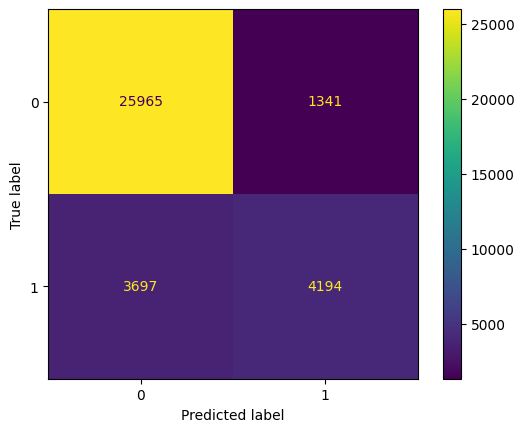

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

params = {
    "max_depth": [5,7],
    "max_features": ["sqrt", None]}
boosting_algo = GradientBoostingClassifier()
boosting_algo_cv = RandomizedSearchCV(boosting_algo, params, cv = 5)
boosting_algo_cv.fit(X_train, y_train)

pred = boosting_algo_cv.predict(X_test)
plot_confusion_matrix(boosting_algo_cv,X_test,y_test)
print(classification_report(y_test, pred))
print("Test set R\N{SUPERSCRIPT TWO}: %.2f%%" % (boosting_algo_cv.score(X_test, y_test)*100.0))

### Stacking Method

The next method we will analyze is **Stacking**, which involves making predictions on the entire dataset with different classifiers (that are not highly correlated). In the second phase, a final classifier is used to make predictions based on the outputs from the previous classifiers. The **CV** parameter refers to **cross-validation**, specifying how many groups the dataset is split into for training (CV-1) and validation (1). In this case, we will use **CV=6**.

We will use the classifiers we applied earlier:

1. `LogisticRegression`  
2. `RandomForestClassifier`  
3. `SVC`

And as the final classifier, we will use `RandomForestClassifier`.

In [42]:
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator = RandomForestClassifier(random_state=42),
    cv = 6
)

We will use a **pipeline** to test the method, scaling the data beforehand.

In [43]:
pipeline = make_pipeline(StandardScaler(),
                         stacking_clf)

In [44]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('stackingclassifier',
                 StackingClassifier(cv=6,
                                    estimators=[('lr',
                                                 LogisticRegression(random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(random_state=42)),
                                                ('svc',
                                                 SVC(probability=True,
                                                     random_state=42))],
                                    final_estimator=RandomForestClassifier(random_state=42)))])

In [45]:
round(pipeline.score(X_test, y_test), 3)

0.839

In addition to the accuracy not being the best, the execution time is excessively high, reaching 7-8 hours.  
Therefore, this method may not be suitable for this dataset.

### Neural Networks Method

Finally, we will use the **Neural Networks** method, which is undoubtedly the fastest of the previous methods. While it may not reach the optimal solution, it is the best in terms of execution time.

First, we will select 10% of the training dataset to serve as the validation set.

In [47]:
X_train_nn, y_train_nn = X_train[:-14000], y_train[:-14000]
X_valid, y_valid = X_train[-14000:], y_train[-14000:]

We create the neural network, which is defined as a sequence of 4 fully connected layers. We specify that the model has 15 features, with the number of neurons in each layer being: 1024, 512, 64, and 1, respectively. Since this is a **binary classification** problem, the final layer consists of a single neuron, and we use the **sigmoid activation** function.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[15]),
    tf.keras.layers.Dense(1024, kernel_initializer = 'uniform', activation="relu"),
    tf.keras.layers.Dense(512, kernel_initializer = 'uniform', activation="relu"),
    tf.keras.layers.Dense(64, kernel_initializer = 'uniform', activation="relu"),
    tf.keras.layers.Dense(1, kernel_initializer = 'uniform', activation="sigmoid")
])

We verify that the neural network has the desired architecture.

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 1024)              16384     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 574,081
Trainable params: 574,081
Non-trainable params: 0
_________________________________________________________________


Next, we define the remaining parameters for the neural network, selecting the **loss function**, **optimizer**, and **metric**. We then choose a total of 20 iterations for the model and execute it.

You can also consider choosing other values for the **iterations** parameter, in orther to reach the best soluction.

In [50]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [51]:
history = model.fit(X_train_nn, y_train_nn, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
2863/2863 [==============================] - 39s 13ms/step - loss: 0.4109 - accuracy: 0.8268 - val_loss: 0.4393 - val_accuracy: 0.8101
Epoch 2/20
2863/2863 [==============================] - 37s 13ms/step - loss: 0.3880 - accuracy: 0.8351 - val_loss: 0.3681 - val_accuracy: 0.8446
Epoch 3/20
2863/2863 [==============================] - 38s 13ms/step - loss: 0.3853 - accuracy: 0.8372 - val_loss: 0.3682 - val_accuracy: 0.8454
Epoch 4/20
2863/2863 [==============================] - 38s 13ms/step - loss: 0.3837 - accuracy: 0.8374 - val_loss: 0.3682 - val_accuracy: 0.8446
Epoch 5/20
2863/2863 [==============================] - 37s 13ms/step - loss: 0.3818 - accuracy: 0.8371 - val_loss: 0.3685 - val_accuracy: 0.8464
Epoch 6/20
2863/2863 [==============================] - 37s 13ms/step - loss: 0.3797 - accuracy: 0.8388 - val_loss: 0.3665 - val_accuracy: 0.8445
Epoch 7/20
2863/2863 [==============================] - 37s 13ms/step - loss: 0.3794 - accuracy: 0.8392 - val_loss: 0.3650 -

### Plotting Training and Validation Scores and Losses

Finally, we plot the **training** and **validation** scores and losses to assess whether any hyperparameters need to be adjusted.

<AxesSubplot:xlabel='Epochs'>

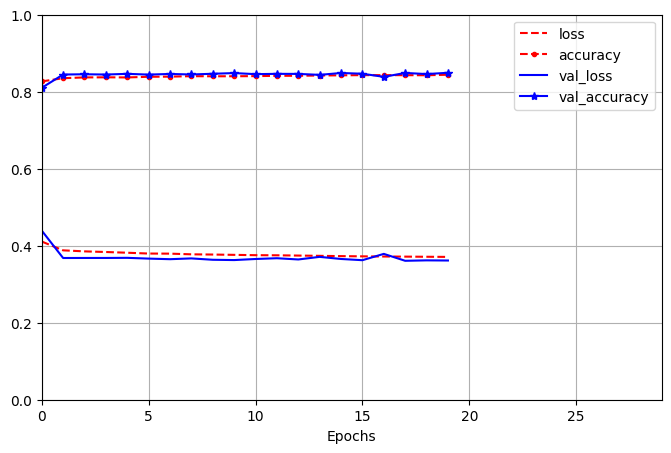

In [53]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0,29], ylim=[0,1], grid=True, xlabel='Epochs',
    style=['r--', 'r--.', 'b-', 'b-*'])

## Results and Conclusion

After using a wide range of different classification methods, we obtained the best result with the **Boosting method**, achieving a score of **85.69**, which is a great percentage, considering that we are predicting whether it will rain tomorrow (1 mm or more), a task that is quite challenging.

However, it is important to note that the highest score is not always the most important factor; execution time also plays a significant role. In this regard, the **Neural Networks** method outperforms the others, as it provides a result quickly. Moreover, it iterates (for the specified number of times) to find the optimal solution, without the need to define the importance of each feature manually.

On the other hand, methods like **Bagging**, **Boosting**, and **Stacking** can be very interesting, as they tend to improve scores without the need to create new classifiers. Once we reach a certain score and cannot improve it further, these methods can often enhance the results. These techniques involve using different classifiers, or the same one multiple times, to consider each method's prediction when making the final prediction. Similar methods include the **Voting Classifier** and **Random Forest**, the latter being particularly useful for selecting relevant variables and discarding unnecessary ones.